# Develop code to fit a single waveform

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 640x480 with 0 Axes>

In [3]:
import lalsimulation as lalsim

In [4]:
import numpy as np
import copy

In [15]:
import waveform_generator
import waveform_utils
import hybrid_utils
import spliced_pn

In [11]:
import os
# download HybSur data file: https://git.ligo.org/lscsoft/lalsuite-extra/-/blob/master/data/lalsimulation/NRHybSur3dq8_lal.h5
# set path
os.environ['LAL_DATA_PATH'] = '/Users/sebastian.khan/Downloads/'

In [70]:
def delta_phi_fn(m, return_complex=False):
    """
    leading order PN imaginary part of complex amplitude
    """
    z = (-1)*(-1.j)**m
    if return_complex:
        return z
    else:
        return np.arctan2(z.imag, z.real)

In [48]:
def plot_fit_hybrid(wf_pn, wf_nr, ell, mm, result, win1, win2, xlim=None):
    wf_pn = copy.deepcopy(wf_pn)
    wf_nr = copy.deepcopy(wf_nr)
    dt_ = result.params['dt']
    dphi_ = result.params['dphi']
    dpsi_ = result.params['dpsi']

    (
        wf_nr
            .apply_time_shift(-dt_)
            .apply_phase_shift(dphi_)
            .apply_polarisation_shift(dpsi_)
    )
    
    fig, axs = plt.subplots(2, 1, figsize=(14,8))
    axs[0].plot(wf_pn.times, wf_pn.hlms[ell,mm].real, label='pn')
    axs[0].plot(wf_nr.times, wf_nr.hlms[ell,mm].real, label='aligned nr', ls='--')
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].axvspan(win1, win2, color='g', alpha=0.2)

    axs[1].plot(wf_pn.times, wf_pn.hlms[ell,mm].imag, label='pn')
    axs[1].plot(wf_nr.times, wf_nr.hlms[ell,mm].imag, label='aligned nr', ls='--')
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].axvspan(win1, win2, color='g', alpha=0.2)

    fig.suptitle(f"l = {ell}, m = {mm}")

    if xlim != None:
        axs[0].set_xlim(xlim[0], xlim[1])
        axs[1].set_xlim(xlim[0], xlim[1])

        mask = (wf_pn.times >= xlim[0]) & (wf_pn.times <= xlim[1])
        min_ = wf_pn.hlms[ell,mm].real[mask].min()
        max_ = wf_pn.hlms[ell,mm].real[mask].max()
        axs[0].set_ylim(min_, max_)
        axs[1].set_ylim(min_, max_)
        
    plt.show()
    plt.close()

In [75]:
hybridise = True
load_wf = 'nr'
# load_wf = 'approx'
# load_wf = 'spliced'
# only one allowed

# NR (in M)
# sample spacing in units of M for output NR time series
delta_t = 0.1

# inspiral (in S)
deltaT = 1/4096

# modes=[(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5),(5,4)]
modes=[(2,2),(3,2),(4,4),(5,4)]

#########################
###### load nr or...
#########################

if load_wf == 'nr':
    nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5" #q=1
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5" #q=2
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5" #q=4
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5" #q=5
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0063_Res5.h5" #q=8
    # nr_hdf5_filename="/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5" #q=10
    # nr_hdf5_filename="/Users/sebastian.khan/Downloads/MAYA0909.h5"
    wf = waveform_generator.get_hdf5_strain(nr_hdf5_filename, modes, delta_t)
    print(wf['metadata'])
    q = wf['metadata']['q']
    
    # stupid trick to change modes if we have equal mass-case
    # we re-load the data
    # if np.isclose(q, 1):
    #     modes = [(2,2),(3,2),(4,4),(5,4)]
    #     wf = waveform_generator.get_hdf5_strain(nr_hdf5_filename, modes, delta_t)

#########################
##### load approximant
#########################

elif load_wf == 'approx':
    
    # q=2
    # modes=[(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
    # modes=[(2,2),(2,1),(3,3),(4,4)]
    # modes=[(2,2),(2,1),(3,3)]
    # approximant=lalsim.SEOBNRv4PHM
    # approximant=lalsim.SpinTaylorT1
    # approximant=lalsim.TaylorT1
    approximant=lalsim.NRHybSur3dq8
    wf = waveform_generator.generate_waveform(
        q,
        modes,
        approximant=approximant,
        f_min=20,
        deltaT=deltaT,
    )

elif load_wf == 'spliced':
    # q=2
    # modes=[(2,2),(2,1),(3,3),(3,2),(4,4),(4,3)]
    wf = spliced_pn.generate_spliced_pn_waveform(q, modes, f_min=20, deltaT=deltaT)


wf_nr = waveform_utils.Waveform(wf['t'], wf['hlm'])
t0_nr, _ = (
    wf_nr
        # .mask(-600)
        .compute_amplitude()
        .compute_phase()
        .compute_frequency()
        .compute_time_of_peak()
)


del wf


if hybridise:
    wf_inspiral = spliced_pn.generate_spliced_pn_waveform(q, modes, f_min=13, deltaT=deltaT)
    wf_inspiral = waveform_utils.Waveform(wf_inspiral['t'], wf_inspiral['hlm'])

    t0_inspiral, _ = (
        wf_inspiral
            # .mask(-600)
            .compute_amplitude()
            .compute_phase()
            .compute_frequency()
            .compute_time_of_peak()
    )
    wf_inspiral.apply_time_shift(-t0_inspiral)
    
    win1, win2 = hybrid_utils.get_window_times(wf_nr, n_cycles_before_window=2, n_cycles_in_window=6)
    time_shift_guess = 0


    fit_modes = [(2,2),(3,2),(4,4)]
    result = hybrid_utils.fit_hybrid(wf_inspiral, wf_nr, win1, win2, fit_modes, time_shift_guess, n_tries=5, max_nfev=100)

    wf_hybrid = hybrid_utils.build_hybrid(wf_inspiral, wf_nr, result.params['dt'], result.params['dphi'], result.params['dpsi'], win1, win2)
    (
        wf_hybrid
            # .mask(-600)
            .compute_amplitude()
            .compute_phase()
            .compute_frequency()
    )

{'q': 1.000000000542, 'filename': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5', 'M': 0.999999970503, 'spin1z': -3.67050658542e-09, 'spin2z': -2.1572848954e-09}


In [76]:
result

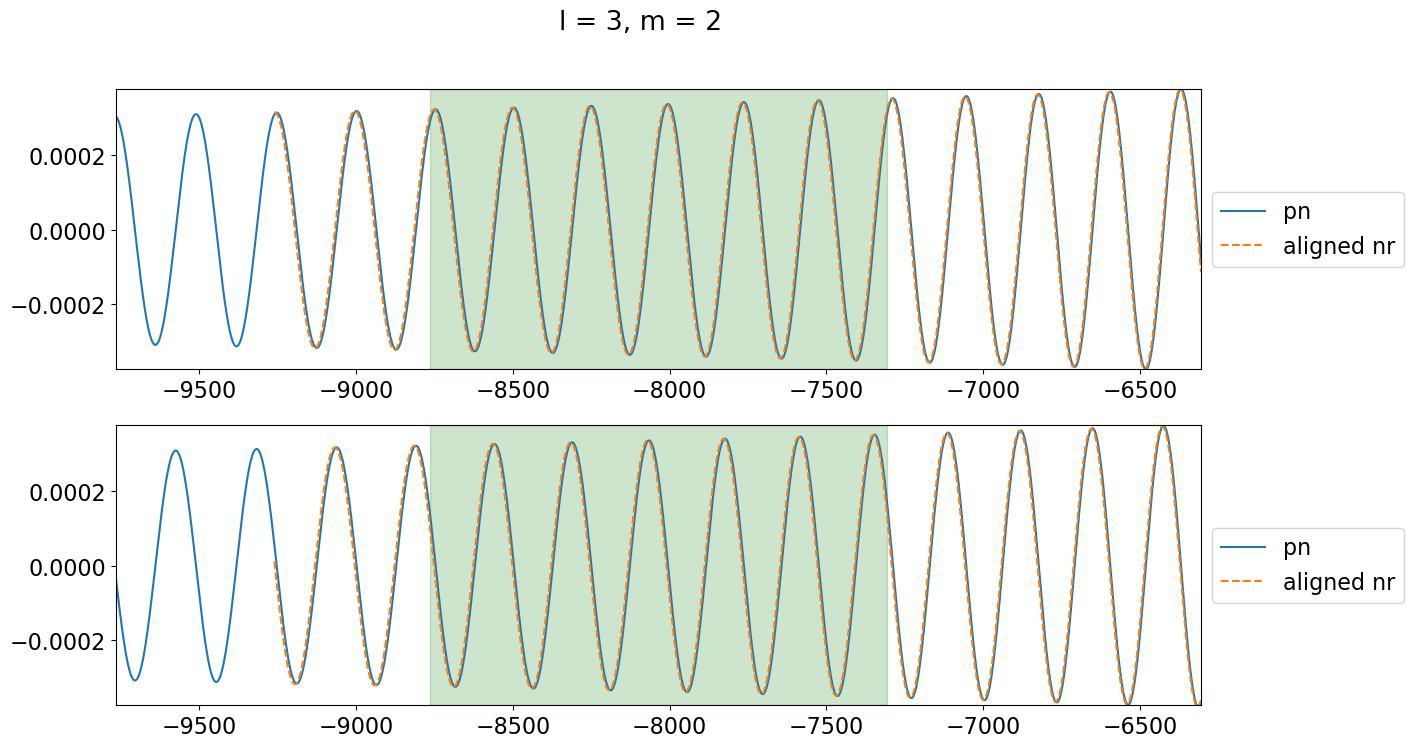

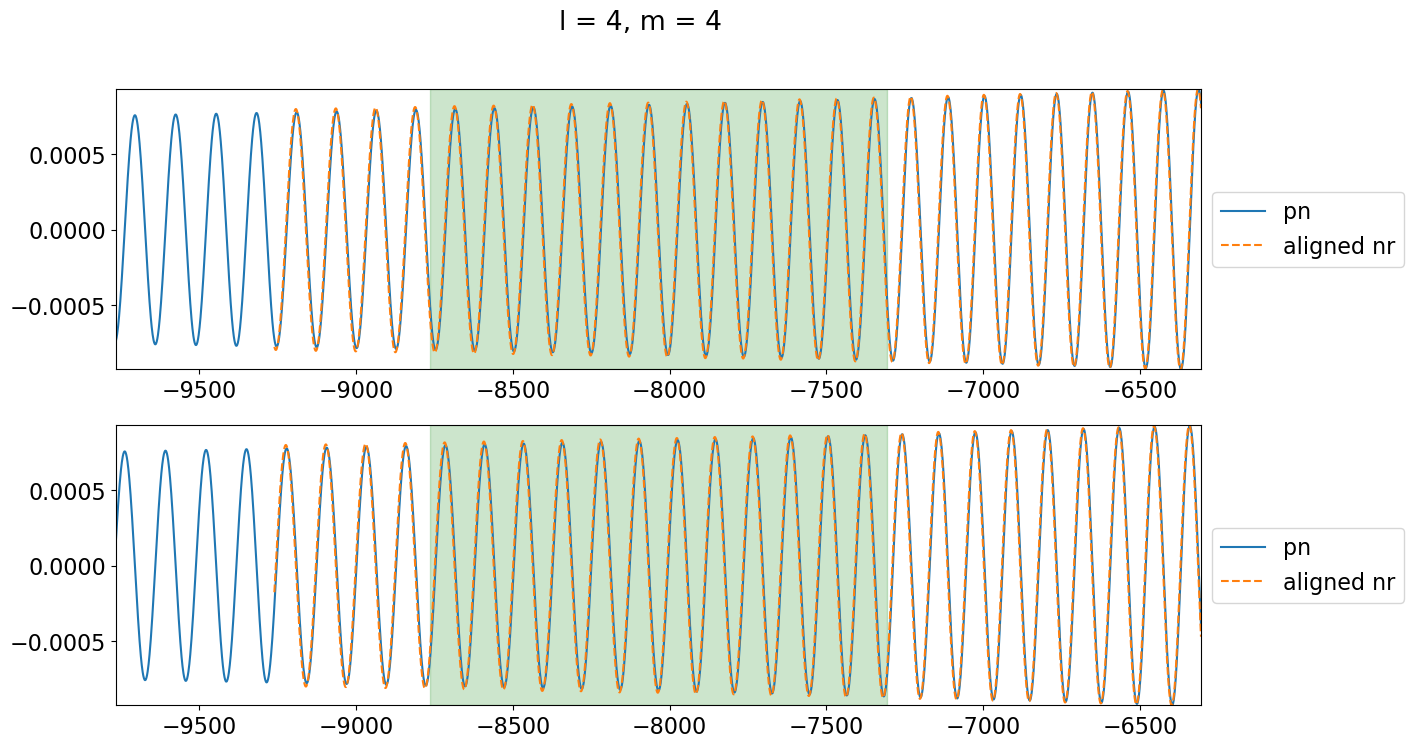

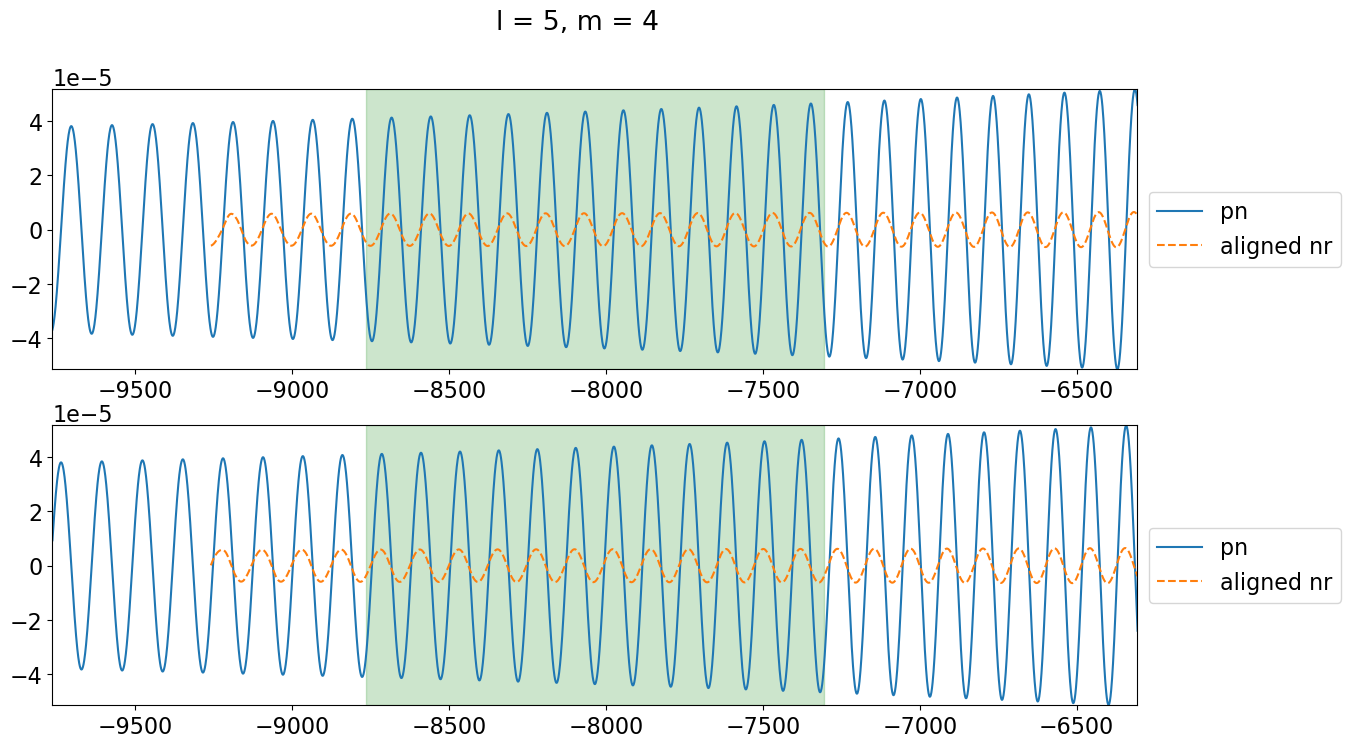

In [77]:
for lm in wf_nr.modes:
    xlim=(win1-1000, win2+1000)
    # xlim=None
    # xlim=(-100, 100)
    plot_fit_hybrid(wf_inspiral, wf_nr, lm[0], lm[1], result, win1, win2, xlim)

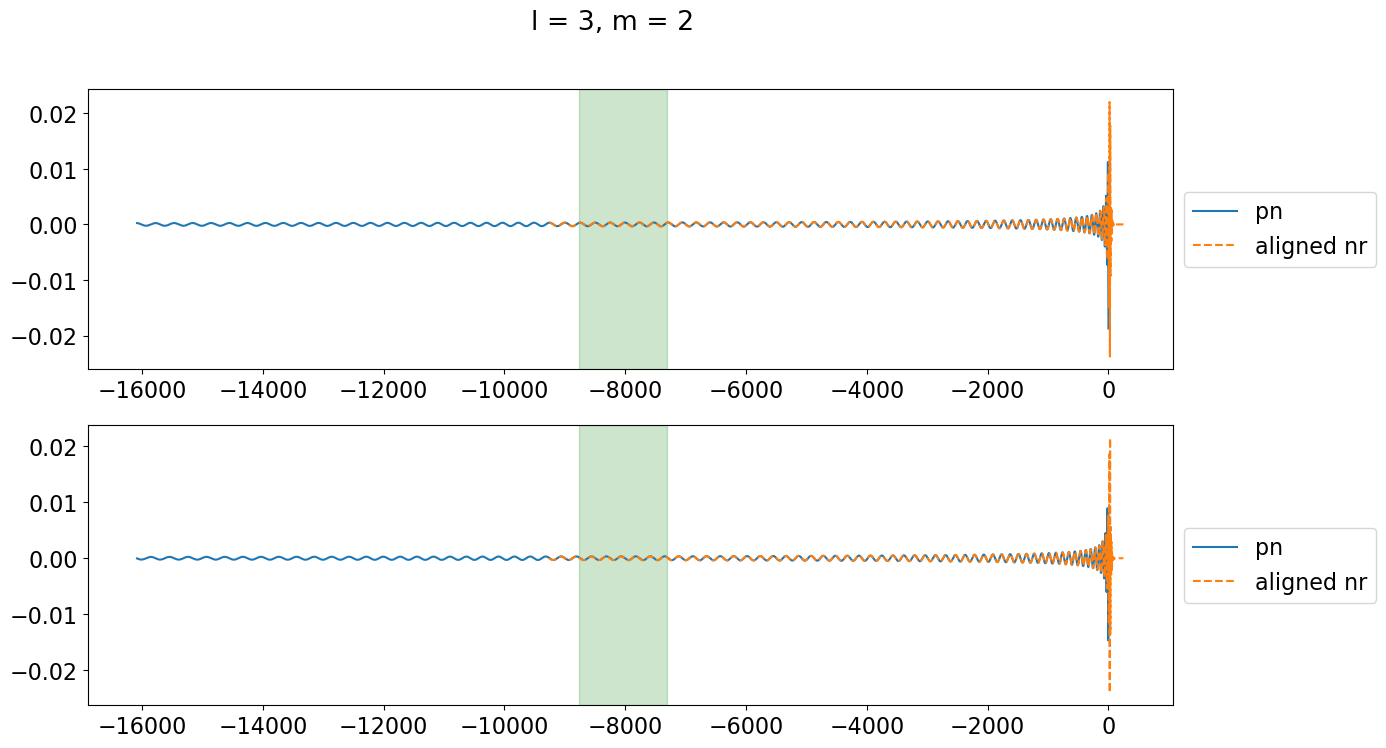

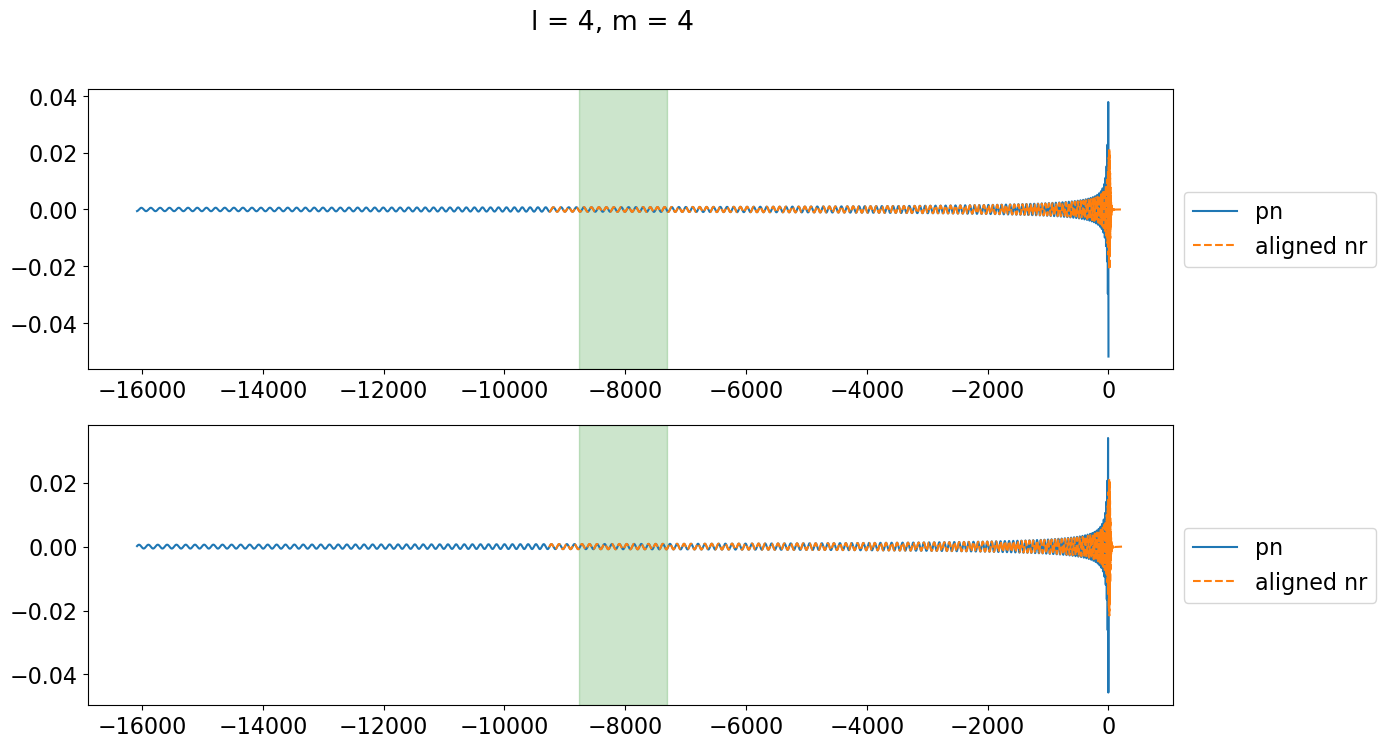

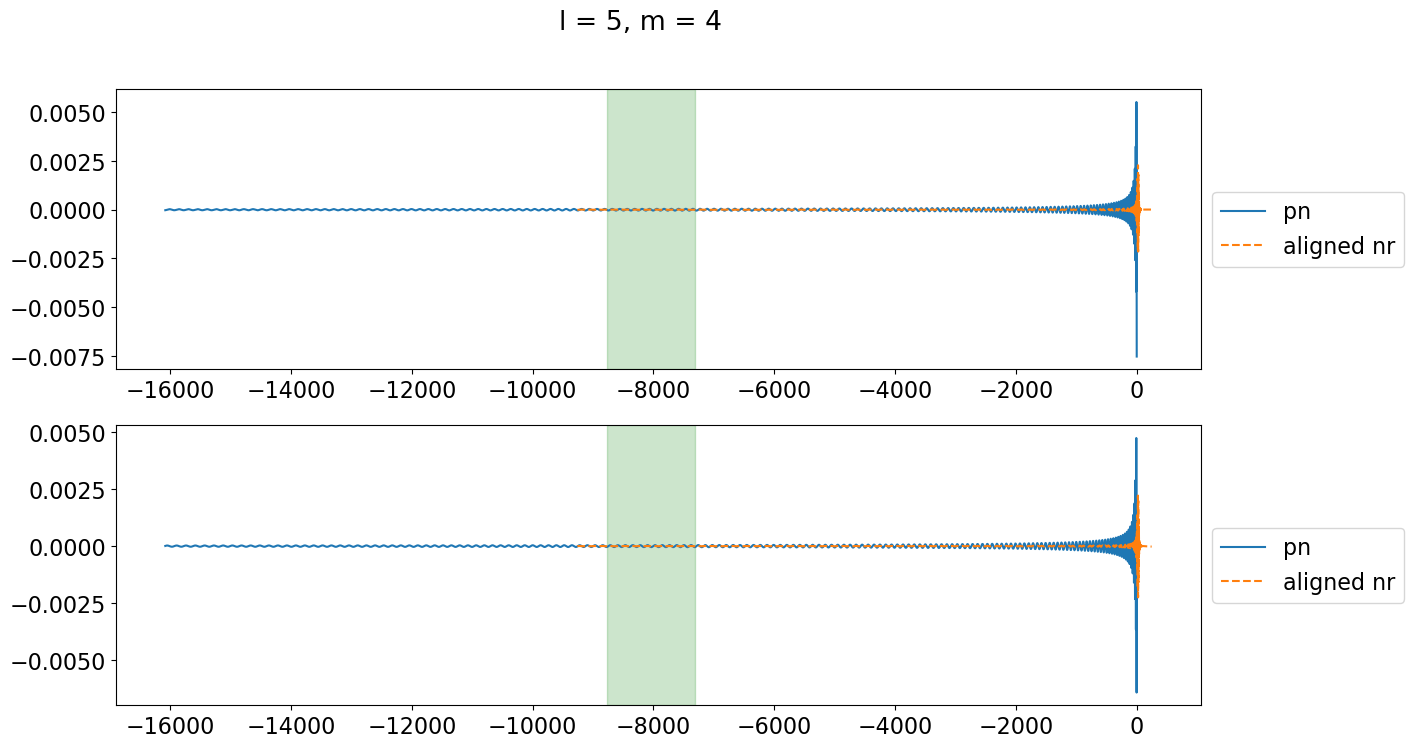

In [78]:
for lm in wf_nr.modes:
    # xlim=(win1-1000, win2+1000)
    xlim=None
    # xlim=(-100, 100)
    plot_fit_hybrid(wf_inspiral, wf_nr, lm[0], lm[1], result, win1, win2, xlim)

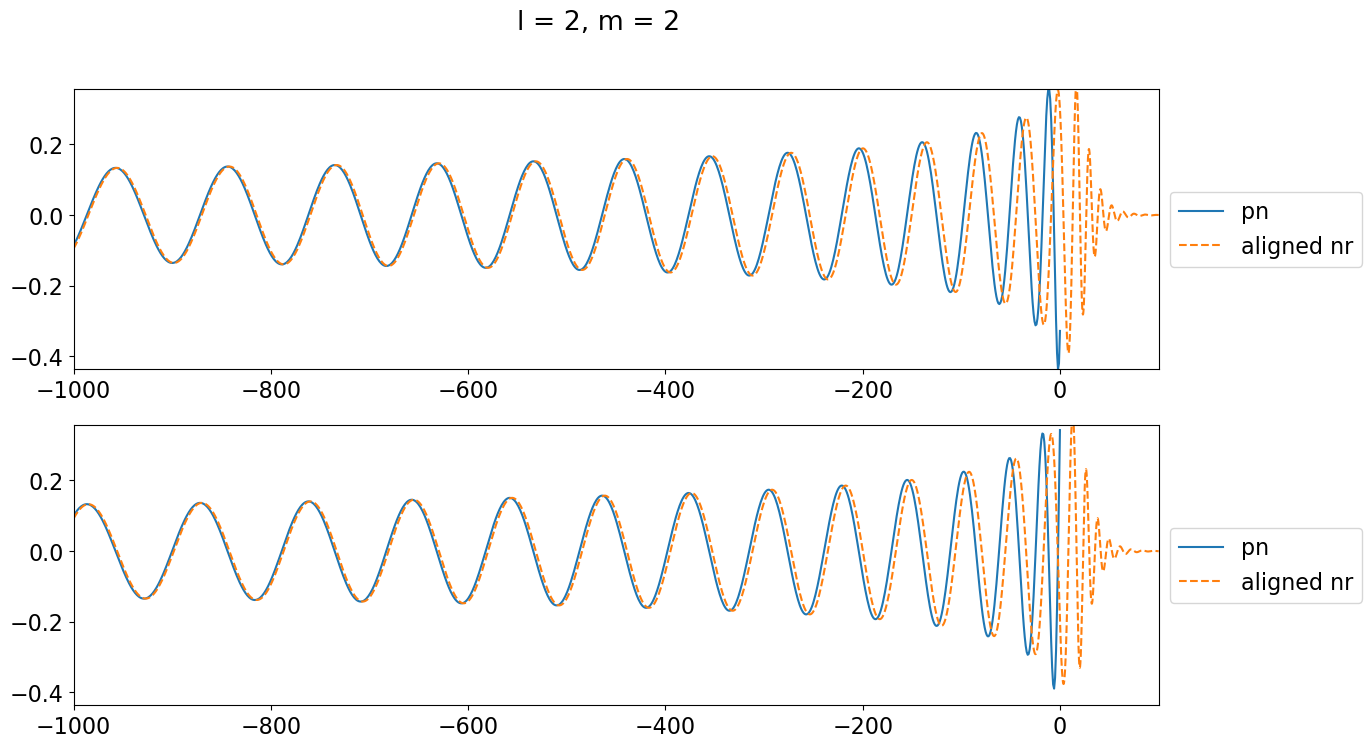

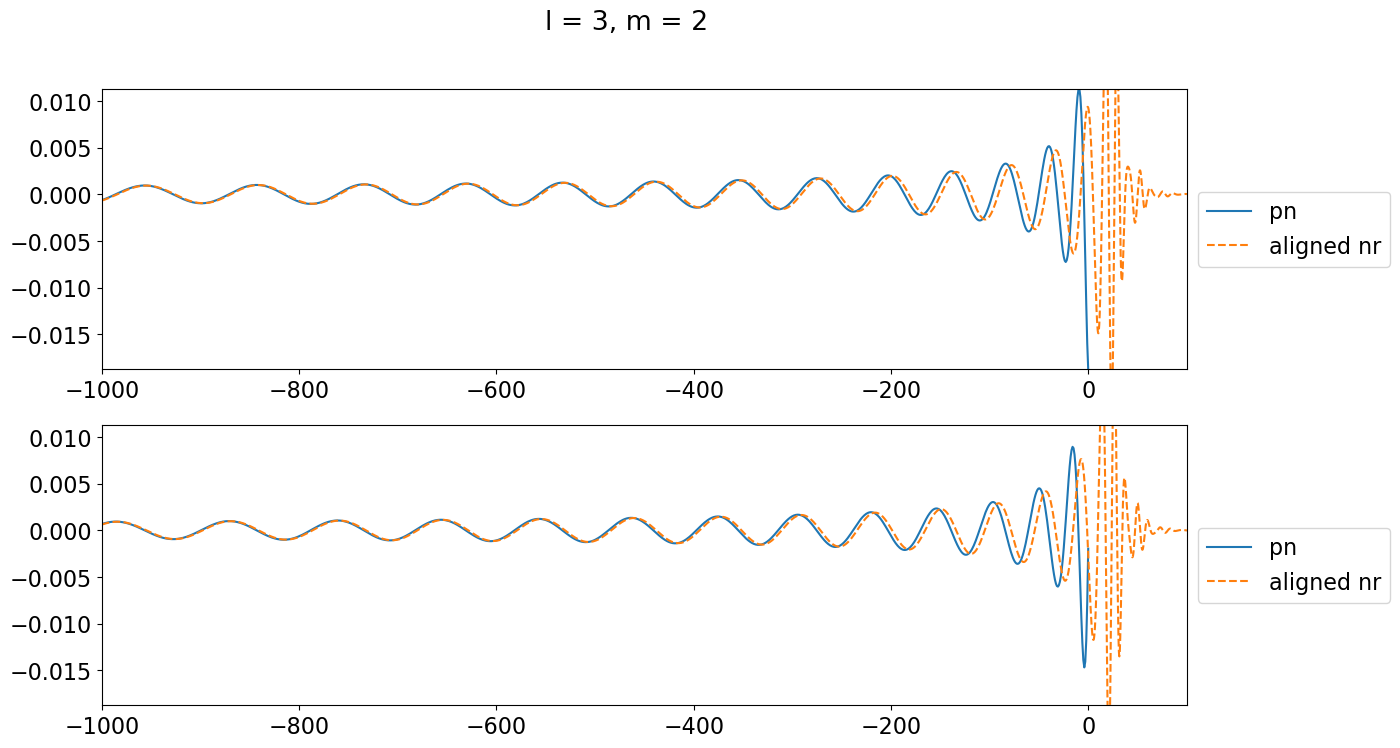

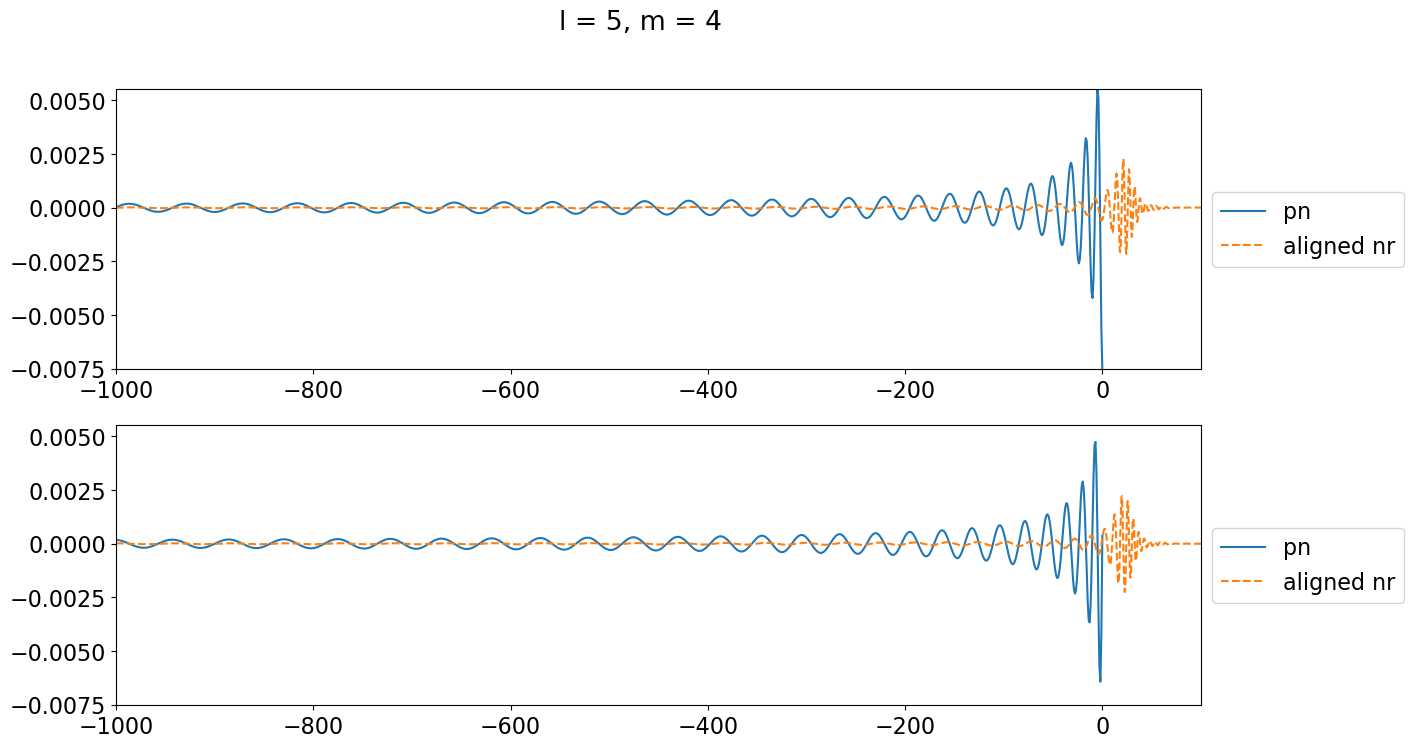

In [79]:
for lm in wf_nr.modes:
    # xlim=(win1-1000, win2+1000)
    # xlim=None
    xlim=(-1000, 100)
    plot_fit_hybrid(wf_inspiral, wf_nr, lm[0], lm[1], result, win1, win2, xlim)

In [80]:
wf_nr

In [81]:
wf_inspiral

In [92]:
plt.figure(figsize=(14, 6), dpi=100)
for i, mode in enumerate(wf_hybrid.modes):
    plt.plot(wf_hybrid.times, wf_hybrid.phases[mode[0], mode[1]]-wf_hybrid.phases[2,2]/2*mode[1], c=f"C{i}", label=f"Hybrid {mode}")
    plt.plot(wf_inspiral.times, wf_inspiral.phases[mode[0], mode[1]]-wf_inspiral.phases[2,2]/2*mode[1], c=f"C{i}", label=f"PN {mode}", ls='-.')
    # plt.plot(wf_nr.times, wf_nr.phases[mode[0], mode[1]]-wf_nr.phases[2,2]/2*mode[1], c=f"C{i}", label=f"NR {mode}", ls='dotted')
    plt.axhline(delta_phi_fn(mode[1]), c=f'C{i}', ls='--', alpha=0.6, label=f"leading PN {mode}")
plt.ylim(-np.pi, 1.3*np.pi)
# plt.xlim(-300, 200)
# plt.xlim(win1-1000, win2+1000)
plt.axvspan(win1, win2, color='g', alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

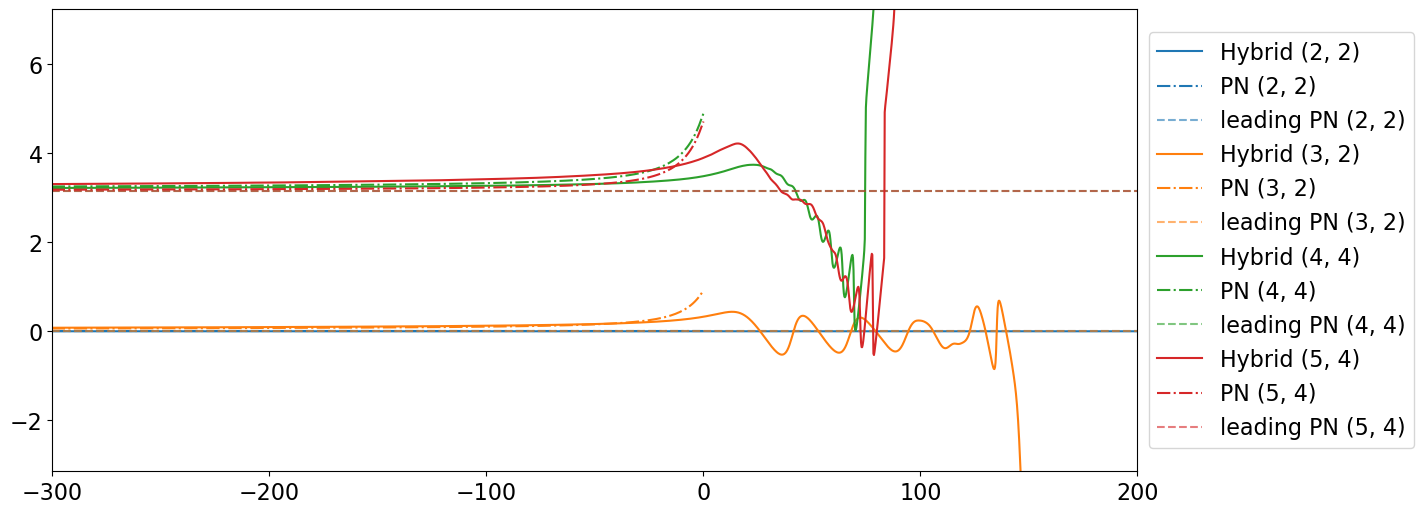

In [93]:
plt.figure(figsize=(14, 6), dpi=100)
for i, mode in enumerate(wf_hybrid.modes):
    plt.plot(wf_hybrid.times, wf_hybrid.phases[mode[0], mode[1]]-wf_hybrid.phases[2,2]/2*mode[1], c=f"C{i}", label=f"Hybrid {mode}")
    plt.plot(wf_inspiral.times, wf_inspiral.phases[mode[0], mode[1]]-wf_inspiral.phases[2,2]/2*mode[1], c=f"C{i}", label=f"PN {mode}", ls='-.')
    # plt.plot(wf_nr.times, wf_nr.phases[mode[0], mode[1]]-wf_nr.phases[2,2]/2*mode[1], c=f"C{i}", label=f"NR {mode}", ls='dotted')
    plt.axhline(delta_phi_fn(mode[1]), c=f'C{i}', ls='--', alpha=0.6, label=f"leading PN {mode}")
plt.ylim(-np.pi, 2.3*np.pi)
plt.xlim(-300, 200)
# plt.xlim(win1-1000, win2+1000)
plt.axvspan(win1, win2, color='g', alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))